# The Battle of Neighborhoods (Week 2)

Introduction:


This final project explores the best locations for French restaurants throughout the city of New York. As New York is the most diverse city in the world (800 languages are spoken in New York), it has a long tradition of different ethnical restaurants.French restaurants are extremely popular, as they offer a healthy alternative to regular American eating habits. That's why Potentially the create a new French restaurant can have great success and consistent profit. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. So our project will attempt to answer the questions “Where should the investor open a French Restaurant?” and “Where should I go If I want great French food?”

Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of French restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by French restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

Problem Statement
What is / are the best location(s) for French cuisine in New York City?
In what Neighborhood and/or borough should the investor open a French restaurant to have the best chance of being successful?
Where would I go in New York City to have the best French food?



Analysis

We will import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [ ]:
#!conda install -c conda-forge folium

In [ ]:
!conda install -c conda-forge geocoder

In [ ]:
#!conda install -c conda-forge geopy --yes

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import os

import folium # map rendering library

#import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:

address = 'New York City, NY'


In [3]:

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


In [4]:

def get_venues(lat,lng):
    
    #set variables
    radius=5000
    LIMIT=500
    
    CLIENT_ID =  'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    VERSION = '20210504' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']                                                        
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df



In [5]:
def get_venue_details(venue_id):
        
    
    CLIENT_ID =  'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    VERSION = '20210504' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    data_frame = pd.DataFrame(venue_details,columns=column_names)
    return  data_frame

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
# get new york data
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

In [11]:
# prepare neighborhood list that contains italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
French_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    French_restaurants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Restaurants in '+Neighborhood+', '+Borough+':'+str(len(French_restaurants)))
    for restaurant_detail in French_restaurants.values.tolist():
        id, name , category=restaurant_detail
        French_rest_ny = French_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Restaurants in Wakefield, Bronx:0
( 2 / 306 ) French Restaurants in Co-op City, Bronx:0
( 3 / 306 ) French Restaurants in Eastchester, Bronx:0
( 4 / 306 ) French Restaurants in Fieldston, Bronx:0
( 5 / 306 ) French Restaurants in Riverdale, Bronx:0
( 6 / 306 ) French Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) French Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) French Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) French Restaurants in Norwood, Bronx:0
( 10 / 306 ) French Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) French Restaurants in Baychester, Bronx:0
( 12 / 306 ) French Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Restaurants in City Island, Bronx:1
( 14 / 306 ) French Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) French Restaurants in University Heights, Bronx:0
( 16 / 306 ) French Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) French Restaurants in Fordham, Bronx:0
( 18 / 306 ) French Restaurants in East Tremont, Bronx:

In [12]:
French_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Bronx,High Bridge,4b80389ff964a520e95d30e3,Yatenga
2,Bronx,Melrose,4b80389ff964a520e95d30e3,Yatenga
3,Bronx,Melrose,553c1b00498e7eb81316bf1b,Mountain Bird
4,Bronx,Melrose,511a937ee88968b8acbba54b,Maison Harlem


In [13]:
French_rest_ny.shape

(83, 4)

Let's save these data as the call to retreive them are limited by FOURSQUARE

In [14]:
French_rest_ny.to_csv('French_rest_ny.csv',index=False)

In [15]:
French_rest_ny_csv=pd.read_csv('French_rest_ny.csv')

In [16]:
French_rest_ny_csv.shape

(83, 4)

In [17]:
French_rest_ny_csv.tail()

,Borough,Neighborhood,ID,Name
78,Brooklyn,Highland Park,5504c149498e3f73684b13a9,L' Antagoniste
79,Brooklyn,Highland Park,439591fcf964a5208c2b1fe3,Chez Oskar
80,Brooklyn,Erasmus,4e7d174cb6340a4da75a2cca,Le Paddock
81,Manhattan,Hudson Yards,4d0bf7e3f29c236ac675bfe7,Buvette
82,Queens,Hammels,4f71ce9de4b0a89fa4b084de,Cuisine By Claudette


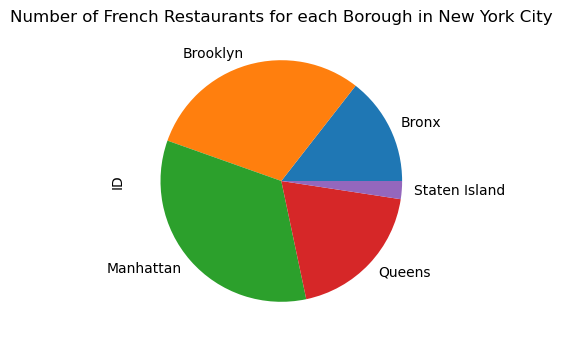

In [18]:
plt.figure(figsize=(8,4), dpi = 100)

# title
plt.title('Number of French Restaurants for each Borough in New York City')

#pie chart
French_rest_ny.groupby('Borough')['ID'].count().plot(kind='pie')

plt.show()

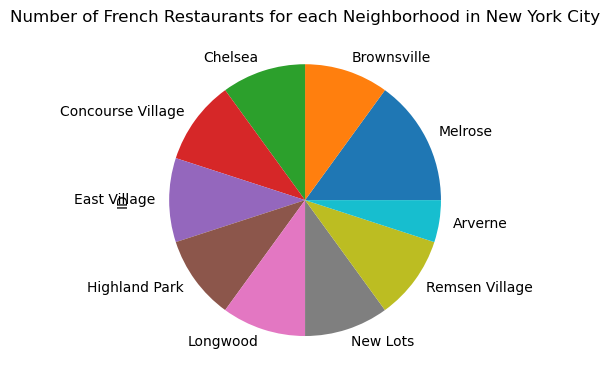

In [19]:
plt.figure(figsize=(8.5,4.5), dpi = 100)

# title
plt.title('Number of French Restaurants for each Neighborhood in New York City')

#pie chart
French_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='pie')

plt.show()

In [19]:
French_rest_ny[French_rest_ny['Neighborhood']=='East Village']

,Borough,Neighborhood,ID,Name
36,Manhattan,East Village,4d0bf7e3f29c236ac675bfe7,Buvette
37,Manhattan,East Village,5db241e86a808900075f6e61,Le Crocodile


Now we will get the ranking of each restaurant for further analysis.

In [36]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
French_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in French_rest_ny.values.tolist():

    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(French_rest_ny),')','processed')
    French_rest_stats_ny = French_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
French_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '6093e5444332e5492dd46c20'}, 'response': {'venue': {'id': '4d7aa83ee540f04d66ba16dc', 'name': 'Bistro SK', 'contact': {'phone': '7188851670', 'formattedPhone': '(718) 885-1670'}, 'location': {'address': '273 City Island Ave', 'lat': 40.84638676701103, 'lng': -73.78626182722242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84638676701103, 'lng': -73.78626182722242}, {'label': 'entrance', 'lat': 40.846234, 'lng': -73.786269}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['273 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bistro-sk/4d7aa83ee540f04d66ba16dc', 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
78,Brooklyn,Highland Park,5504c149498e3f73684b13a9,L' Antagoniste,87,8.5,28
79,Brooklyn,Highland Park,439591fcf964a5208c2b1fe3,Chez Oskar,201,8.3,97
80,Brooklyn,Erasmus,4e7d174cb6340a4da75a2cca,Le Paddock,141,8.9,56
81,Manhattan,Hudson Yards,4d0bf7e3f29c236ac675bfe7,Buvette,1864,9.3,527
82,Queens,Hammels,4f71ce9de4b0a89fa4b084de,Cuisine By Claudette,24,8.5,9


In [37]:
print('Shape of French restaurant static by Neighborhood :',French_rest_stats_ny.shape,'Versus shape of the actual number of French restaurant :',French_rest_ny.shape)

Shape of French restaurant static by Neighborhood : (83, 7) Versus shape of the actual number of French restaurant : (83, 4)


Now that we've obtain data for all French restaurants in New York and as the numbre of calls to get details for venue are premium call and have limit of 500 per month, as done earlier lets save those datas to a csv file that we'll use for the rest of our study

In [38]:
French_rest_stats_ny.to_csv('French_rest_stats_ny.csv',index=False)

In [39]:
French_rest_stats_ny_csv=pd.read_csv('French_rest_stats_ny.csv')

In [40]:
French_rest_stats_ny_csv.shape

(83, 7)

In [41]:
French_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,12,7.5,7
1,Bronx,High Bridge,4b80389ff964a520e95d30e3,Yatenga,104,8.5,62
2,Bronx,Melrose,4b80389ff964a520e95d30e3,Yatenga,104,8.5,62
3,Bronx,Melrose,553c1b00498e7eb81316bf1b,Mountain Bird,80,8.9,18
4,Bronx,Melrose,511a937ee88968b8acbba54b,Maison Harlem,289,8.6,88


In [42]:
French_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       83 non-null     object 
 1   Neighborhood  83 non-null     object 
 2   ID            83 non-null     object 
 3   Name          83 non-null     object 
 4   Likes         83 non-null     int64  
 5   Rating        83 non-null     float64
 6   Tips          83 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.7+ KB


It appear that Likes and Tips are string values. We would need to convert them into float for further analysis

In [43]:
French_rest_stats_ny_csv['Likes']=French_rest_stats_ny_csv['Likes'].astype('float64')
French_rest_stats_ny_csv['Tips']=French_rest_stats_ny_csv['Tips'].astype('float64')
French_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       83 non-null     object 
 1   Neighborhood  83 non-null     object 
 2   ID            83 non-null     object 
 3   Name          83 non-null     object 
 4   Likes         83 non-null     float64
 5   Rating        83 non-null     float64
 6   Tips          83 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.7+ KB


# Restaurant with maximum Likes

In [44]:
French_rest_stats_ny_csv.iloc[French_rest_stats_ny_csv['Likes'].idxmax]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1864
Rating                               9.3
Tips                                 527
Name: 25, dtype: object

# Restaurant with maximum Rating

In [45]:
French_rest_stats_ny_csv.iloc[French_rest_stats_ny_csv['Rating'].idxmax]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5db241e86a808900075f6e61
Name                        Le Crocodile
Likes                                 59
Rating                               9.4
Tips                                  12
Name: 11, dtype: object

# Restaurant with maximum Tips

In [46]:
French_rest_stats_ny_csv.iloc[French_rest_stats_ny_csv['Tips'].idxmax]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1864
Rating                               9.3
Tips                                 527
Name: 25, dtype: object

Let check in which neighborhood French restaurent are the better rated

In [47]:
ny_neighborhood_stats=French_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
40,Long Island City,9.4
52,North Side,9.4
22,East Williamsburg,9.4
63,South Side,9.4
64,Stuyvesant Town,9.4
65,Sunnyside,9.4
35,Hunters Point,9.4
42,Lower East Side,9.4
69,Vinegar Hill,9.4
28,Greenpoint,9.4


What if we illustrate the average rating at the Borough Level

In [48]:
ny_borhood_stats=French_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borhood_stats.columns=['Borough','Average Rating']


ny_borhood_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,9.228571
1,Brooklyn,8.860000
3,Queens,8.750000
0,Bronx,8.566667
4,Staten Island,7.300000


It appear that Manhattan have the better French restaurants

In [49]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Arverne,40.589144,-73.791992,8.500000
1,Manhattan,Battery Park City,40.711932,-74.016869,9.300000
2,Queens,Belle Harbor,40.576156,-73.854018,8.500000
3,Queens,Blissville,40.737251,-73.932442,9.400000
4,Brooklyn,Borough Park,40.633131,-73.990498,8.900000
5,Queens,Broad Channel,40.603027,-73.820055,8.500000
6,Brooklyn,Broadway Junction,40.677861,-73.903317,8.500000
7,Brooklyn,Brownsville,40.663950,-73.910235,8.550000
8,Staten Island,Bulls Head,40.609592,-74.159409,7.300000
9,Brooklyn,Bushwick,40.698116,-73.925258,9.000000


We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [50]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
1,Manhattan,Battery Park City,40.711932,-74.016869,9.30
3,Queens,Blissville,40.737251,-73.932442,9.40
9,Brooklyn,Bushwick,40.698116,-73.925258,9.00
10,Manhattan,Carnegie Hill,40.782683,-73.953256,9.10
14,Manhattan,Chinatown,40.715618,-73.994279,9.30
16,Manhattan,Civic Center,40.715229,-74.005415,9.30
17,Manhattan,Clinton,40.759101,-73.996119,9.30
22,Manhattan,East Village,40.727847,-73.982226,9.35
23,Brooklyn,East Williamsburg,40.708492,-73.938858,9.40
25,Manhattan,Financial District,40.707107,-74.010665,9.30


Now we can show this data on a map

In [51]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [52]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

<ipython-input-52-dc22b1634a36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [53]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Results

This study on French restaurant in New-York show that the Borough with the better rated french restaurant are Manhattan follow by Brooklyn.

# Conclusion

In New-york according to the data available on foursquare and Wekipedia regarding French restaurent the five neighborhood where we can find the bettre French restaurant are :
- Hunters
- Sunnyside
- East Willamsburg
- Long Island City
- Lower East Side

All rated 9,4 which constitue the highest rate.
Manhattan is the best place to stay if you like French Cuisine and if you want to open a  trendy new French restaurant in New City 